In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/ericmjl/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.0-64/cuda_ndarray', '-I/home/ericmjl/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda', '-I/home/ericmjl/anaconda/lib/python3.6/site-packages/numpy/core/include', '-I/home/ericmjl/anaconda/include/python3.6m', '-I/home/ericmjl/anaconda/lib/python3.6/site-packages/theano/gof', '-o', '/home/ericmjl/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.0-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-L/home/ericmjl/anaconda/lib', '-lcublas', '-lpython3.6m', '-lcudart']


In [53]:
# Generate some fake data.
x_concs = np.arange(0, 100, 1).reshape(-1, 1)
log_xconcs = np.log(x_concs)
ic50_true = np.array([42, 13, 88])
ic50_true = ic50_true.reshape(-1, ic50_true.shape[0])
beta_true = 1
slope_true = 1
intercept_true = 150
# y_true = slope_true * x_concs + intercept_true

y_true = beta_true / (1 + np.exp(x_concs - ic50_true))

y_noisy = y_true + np.random.normal(0, 0.15, size=y_true.shape)  # homoskedastic error
y_noisy

array([[  1.24283502e+00,   9.79611142e-01,   1.11205447e+00],
       [  9.96602495e-01,   8.86316156e-01,   7.85450443e-01],
       [  1.00467577e+00,   1.06324699e+00,   1.21722915e+00],
       [  1.11119528e+00,   1.08496828e+00,   8.33249587e-01],
       [  1.13827049e+00,   1.17066976e+00,   9.73696168e-01],
       [  1.23362324e+00,   9.76492020e-01,   1.33293132e+00],
       [  9.46409713e-01,   1.02208311e+00,   1.24329774e+00],
       [  9.32954517e-01,   9.11583942e-01,   9.19528843e-01],
       [  1.17236220e+00,   1.01422827e+00,   1.16256457e+00],
       [  1.00579106e+00,   9.45668852e-01,   8.61177488e-01],
       [  1.11280393e+00,   9.21471322e-01,   1.06631260e+00],
       [  1.31793788e+00,   8.87673026e-01,   9.48579704e-01],
       [  9.95670744e-01,   6.55461236e-01,   9.69921389e-01],
       [  1.09232904e+00,   5.30590801e-01,   1.01250692e+00],
       [  1.01391210e+00,   2.08576456e-01,   1.22280868e+00],
       [  1.25647472e+00,  -1.67062069e-01,   9.2505234

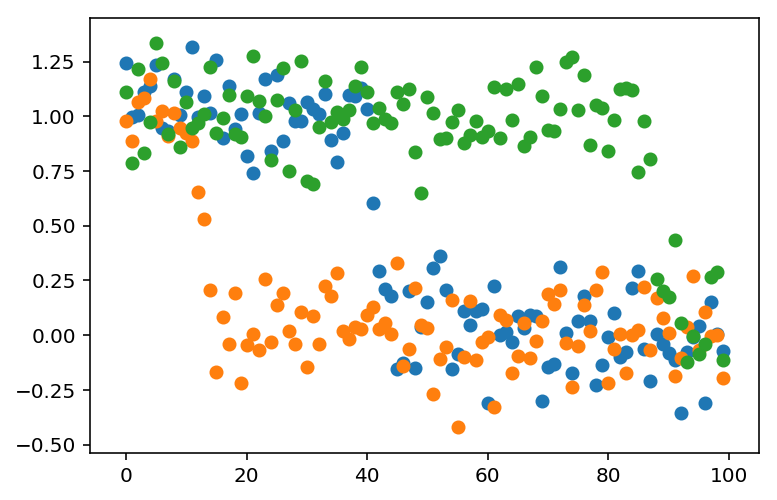

In [54]:
plt.scatter(x_concs, y_noisy[:, 0])
plt.scatter(x_concs, y_noisy[:, 1])
plt.scatter(x_concs, y_noisy[:, 2])

In [55]:
concentrations = np.concatenate([x_concs] * ic50_true.shape[1])
concentrations

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],

In [56]:
concentrations.shape

(300, 1)

In [57]:
y_noisy.flatten(order='F')

array([  1.24283502e+00,   9.96602495e-01,   1.00467577e+00,
         1.11119528e+00,   1.13827049e+00,   1.23362324e+00,
         9.46409713e-01,   9.32954517e-01,   1.17236220e+00,
         1.00579106e+00,   1.11280393e+00,   1.31793788e+00,
         9.95670744e-01,   1.09232904e+00,   1.01391210e+00,
         1.25647472e+00,   9.02109908e-01,   1.13881920e+00,
         9.41708209e-01,   1.01214980e+00,   8.16325381e-01,
         7.40453718e-01,   1.01553797e+00,   1.17109348e+00,
         8.42623717e-01,   1.19049741e+00,   8.89301645e-01,
         1.06132827e+00,   9.80074264e-01,   9.76370156e-01,
         1.06416507e+00,   1.03451609e+00,   1.00864448e+00,
         1.10230050e+00,   8.90224101e-01,   7.89447605e-01,
         9.25351770e-01,   1.09541372e+00,   1.09191394e+00,
         1.13114356e+00,   1.03352059e+00,   6.02902722e-01,
         2.94178802e-01,   2.09243932e-01,   1.76926084e-01,
        -1.54342024e-01,  -1.28305117e-01,   2.02575041e-01,
        -1.51735126e-01,

In [58]:
x_concs.shape[0]

100

In [59]:
data = pd.DataFrame()
data['concentrations'] = concentrations.reshape(concentrations.shape[0],)
data['measurements'] = y_noisy.flatten(order='F')

drugs = []
for i in range(ic50_true.shape[1]):
    drugs.extend([i] * x_concs.shape[0])
data['drug'] = drugs

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

le = LabelEncoder()
data['idxs'] = le.fit_transform(data['drug'])

# Normalize data['measurements'] to 0-1
# mms = MinMaxScaler()
# data['measurements'] = mms.fit_transform(data['measurements'].values.reshape(-1, 1))

In [60]:
data

,concentrations,measurements,drug,idxs
0,0,1.242835,0,0
1,1,0.996602,0,0
2,2,1.004676,0,0
3,3,1.111195,0,0
4,4,1.138270,0,0
5,5,1.233623,0,0
6,6,0.946410,0,0
7,7,0.932955,0,0
8,8,1.172362,0,0
9,9,1.005791,0,0


In [61]:
with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sd=100**2, shape=len(set(data['idxs'])))    
    noise = pm.HalfCauchy('noise', beta=100**2, shape=len(set(data['idxs'])))
    ic50 = pm.Normal('IC50', sd=100**2, shape=len(set(data['idxs'])))
    measurements = beta[data['idxs']] / (1 + np.exp(data['concentrations'].values - ic50[data['idxs']]))

    
    y_like = pm.Normal('y_like', mu=measurements, sd=noise[data['idxs']], observed=data['measurements'])

In [62]:
with model:
    trace = pm.sample(draws=10000, step=pm.Metropolis(), start=pm.find_MAP())

Optimization terminated successfully.
         Current function value: -56.780489
         Iterations: 93


100%|██████████| 10000/10000 [00:02<00:00, 3369.27it/s]

         Function evaluations: 163
         Gradient evaluations: 163


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff234228d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7eff229a3908>]], dtype=object)

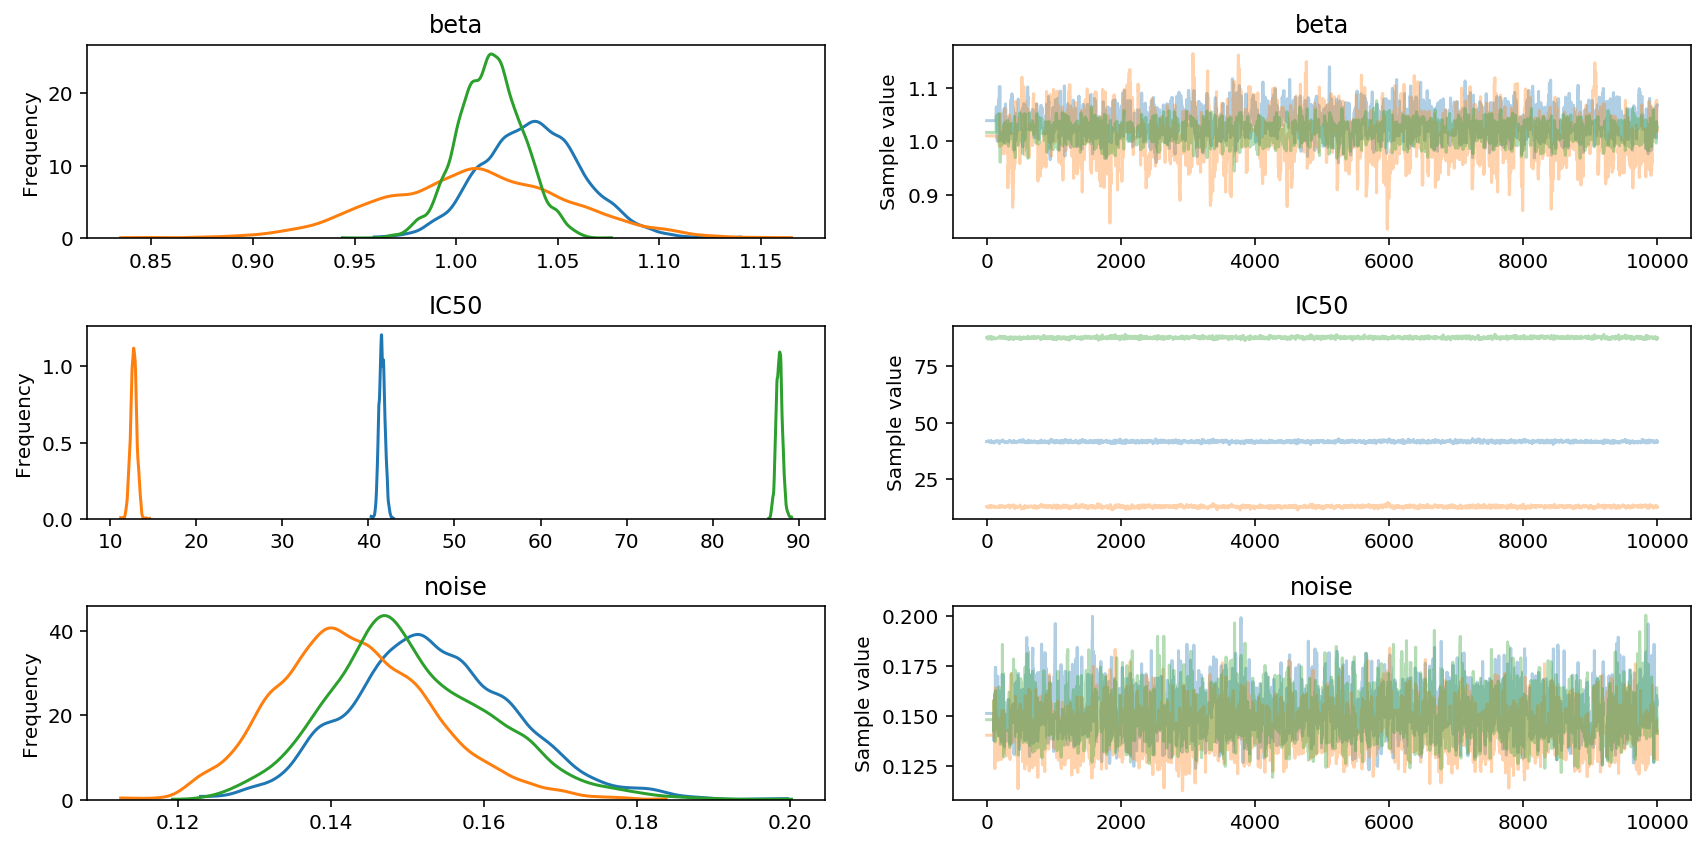

In [63]:
pm.traceplot(trace)

In [64]:
pm.summary(trace)


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.038            0.025            0.001            [0.990, 1.085]
  1.009            0.045            0.002            [0.925, 1.100]
  1.017            0.016            0.000            [0.988, 1.051]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.990          1.021          1.038          1.054          1.086
  0.921          0.979          1.010          1.039          1.098
  0.984          1.006          1.017          1.027          1.049


IC50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  41.569           0.343            0.011            [40.937, 42.238]
  12.702           0.369            0.015            [11.966,